In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
import jax.scipy.special as jsp
from jax.numpy import heaviside
from trout import *
from functools import lru_cache
from jax.flatten_util import ravel_pytree
from scipy.integrate import cumulative_trapezoid as cumtrapz
import pandas as pd
from matplotlib import rc
font={'size':18}
rc('font',**font)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Thermal Unmixing of Unblocking Temperatures (TROUT)
### Introduction
This notebook produces the Figures for the paper on the TROUT method and provides examples of how to use the functions in TROUT
### Importing demag data
This next cell imports the magic data tables from a set of MagiC formatted data in the Zijderveld plot.

In [2]:
meas_data,sample_data,site_data=import_direction_data('SantosTauxeSpecimens/')
specimen='mc109e-szb' #Name of the specimen we want to plot

-I- Using online data model
-I- Getting method codes from earthref.org
-I- Importing controlled vocabularies from https://earthref.org


The following cell converts the magic tables into a format for use in TROUT. zijd_data is an array of the demag data, Ts_base are the temperature steps used to demagnetize the data, Ts_data are scaled versions of the temperatures for the TROUT model. Datatype is a string describing the type of demag experiment (In this case "Thermal") and expon is the exponent used to scale the temperatures.

In [3]:
zijd_data,Ts_base,Ts_data,Ts,datatype,expon=prepare_specimen_data(specimen,meas_data,sample_data,site_data)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Figure 1 - plotting Zijderveld plots.
This code demonstrates how to plot Zijderveld plots with this code, and plots Figure 1 from the paper.

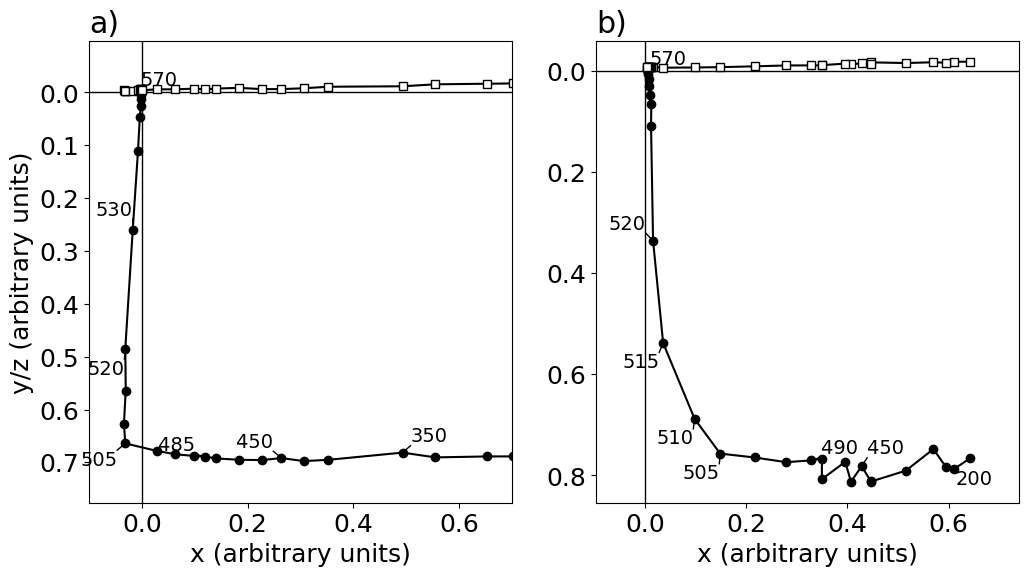

In [4]:
# Plot a figure axis
fig,ax=plt.subplots(1,2,figsize=(12,6))

#Plot Zijderveld plot on axis
plot_zijd_data(ax[0],zijd_data,Ts_base)

#Choose a new specimen and get data
specimen='jm009f-czb'
zijd_data,Ts_base,Ts_data,Ts,datatype,expon=prepare_specimen_data(specimen,meas_data,sample_data,site_data)

#Plot zijderveld data
plot_zijd_data(ax[1],zijd_data,Ts_base)

ax[0].set_xlabel('x (arbitrary units)')

ax[0].set_ylabel('y/z (arbitrary units)');
ax[1].set_xlabel('x (arbitrary units)')
ax[0].set_title('a)',loc='left')
ax[1].set_title('b)',loc='left')
ax[0].set_xlim(-0.1,0.7)
plt.savefig('Figures/straight_vs_curved.pdf',bbox_inches='tight')

### Figure 2 - The TROUT forward model
The TROUT model can produce a set of predicted data from parameters including the field direction, the magnitude of the magnetization and the Skewed Generalized Gaussian (SGG) distribution of unblocking temperatures for each component.

In [5]:
# Initialize Parameters
Bs=np.array([[1,0,0],[0,0,1]]) # Field Directions
cs=np.array([1/np.sqrt(2),1/np.sqrt(2)]) #Magnitudes of each component

#SGG Distribution parameters
mus=np.array([450,500])
sds=np.array([100,100])
ps=np.array([10,10])
q_stars=np.array([5,-5])
qs=2/np.pi*np.arctan(1/q_stars)

We can predict data from the TROUT model using the pred_data function

In [6]:
pred_data=construct_pred_data(Bs,Ts_base,cs,mus,sds,ps,qs)

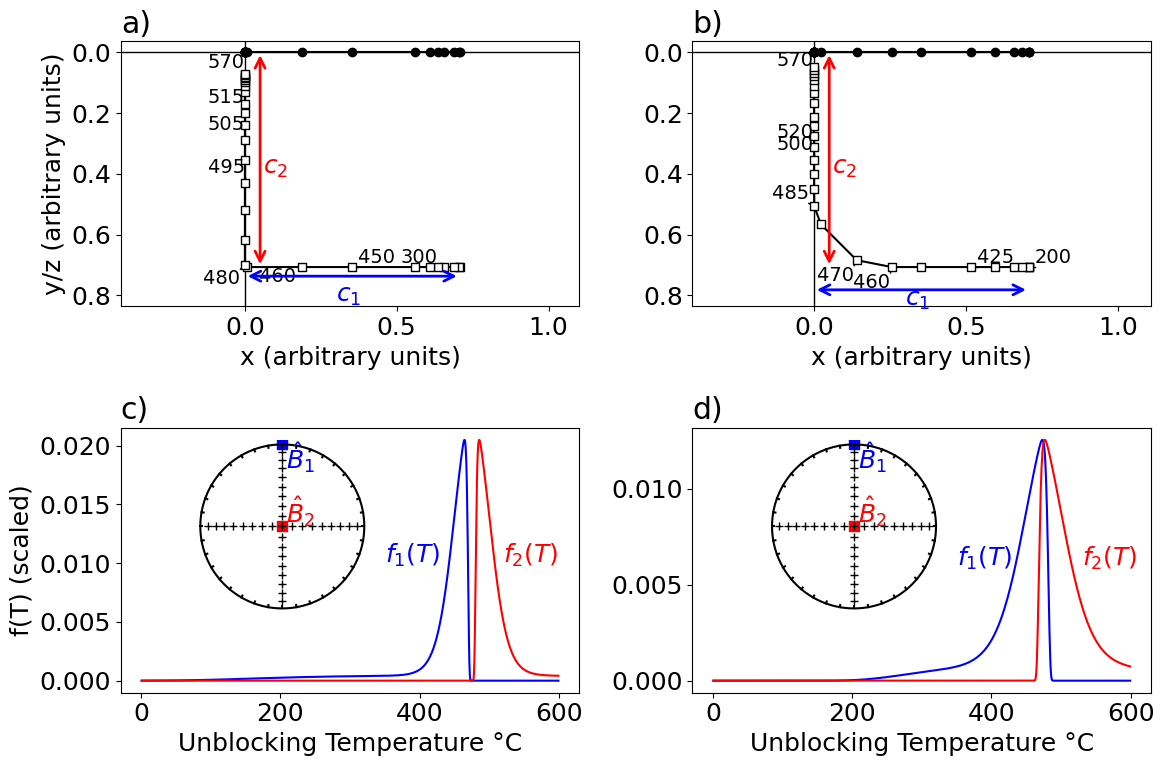

In [7]:
fig,ax=plt.subplots(2,2,figsize=(12,8))

#Plot Predicted data on Zijderveld plot
plot_zijd_data(ax[0,0],np.array(pred_data),Ts_base) 
#Plot unblocking temperature distribution
dist_plot(ax[1,0],Ts_base,cs,mus,sds,np.log(ps),q_stars,0,colors=['b','r']) 

#We're changing the "Q" arameter of the SGG distribution for b),d).
q_stars_2=np.array([3,-3])
qs_2=2/np.pi*np.arctan(1/q_stars_2)

#Repeat previous plots.
pred_data=construct_pred_data(Bs,Ts_base,cs,mus,sds,ps,qs_2)
plot_zijd_data(ax[0,1],np.array(pred_data),Ts_base)
dist_plot(ax[1,1],Ts_base,cs,mus,sds,np.log(ps),q_stars_2,0,colors=['b','r'])

#Create inset axes for equal-area plots
axins0=inset_axes(ax[1,0], width='65%', height='65%',loc='upper left')
axins1=inset_axes(ax[1,1], width='65%', height='65%',loc='upper left')

#Plot equal area examples
plot_net(ax=axins0)
plot_net(ax=axins1)

#Plot data on c)
di_block=pmag.cart2dir([Bs[0]])
plot_di(di_block=di_block,color='b',marker='s',ax=axins1,markersize=50)
plot_di(di_block=di_block,color='b',marker='s',ax=axins0,markersize=50)

#Plot data on d)
di_block=pmag.cart2dir([Bs[1]])
plot_di(di_block=di_block,color='r',marker='s',ax=axins1,markersize=50)
plot_di(di_block=di_block,color='r',marker='s',ax=axins0,markersize=50)


###Figure Layout and Annotations
ax[0,0].set_xlabel('x (arbitrary units)')
ax[0,1].set_xlabel('x (arbitrary units)')
ax[0,0].set_ylabel('y/z (arbitrary units)')
ax[1,0].set_xlabel('Unblocking Temperature °C')
ax[1,1].set_xlabel('Unblocking Temperature °C')
ax[1,0].set_ylabel('f(T) (scaled)')
ax[0,0].annotate('', xy=(0.05,0), xytext=(0.05,1/np.sqrt(2)),arrowprops=dict(arrowstyle='<->',color='r',lw=2))
ax[0,0].annotate('', xy=(0,1/np.sqrt(2)+0.03), xytext=(1/np.sqrt(2),1/np.sqrt(2)+0.03),arrowprops=dict(arrowstyle='<->',color='b',lw=2))
ax[0,0].set_ylim(0.9,-0.1)
ax[0,0].text(0.06,0.4,'$c_2$',color='r',fontsize=18)
ax[0,0].text(0.3,0.82,'$c_1$',color='b',fontsize=18)
ax[0,1].annotate('', xy=(0.05,0), xytext=(0.05,1/np.sqrt(2)),arrowprops=dict(arrowstyle='<->',color='r',lw=2))
ax[0,1].annotate('', xy=(0,1/np.sqrt(2)+0.075), xytext=(1/np.sqrt(2),1/np.sqrt(2)+0.075),arrowprops=dict(arrowstyle='<->',color='b',lw=2))
ax[0,1].set_ylim(0.9,-0.1)
ax[0,1].text(0.06,0.4,'$c_2$',color='r',fontsize=18)
ax[0,1].text(0.3,0.835,'$c_1$',color='b',fontsize=18)
ax[1,0].text(350,0.01,'$f_1(T)$',fontsize=18,color='b')
ax[1,0].text(520,0.01,'$f_2(T)$',fontsize=18,color='r')
ax[1,1].text(350,0.006,'$f_1(T)$',fontsize=18,color='b')
ax[1,1].text(530,0.006,'$f_2(T)$',fontsize=18,color='r')
axins1.text(0.05,0.05,'$\hat{B}_{2}$',color='r',fontsize=18)
axins1.text(0.05,0.7,'$\hat{B}_{1}$',color='b',fontsize=18)
axins0.text(0.05,0.05,'$\hat{B}_{2}$',color='r',fontsize=18)
axins0.text(0.05,0.7,'$\hat{B}_{1}$',color='b',fontsize=18)
ax[0,0].set_title('a)',loc='left')
ax[0,1].set_title('b)',loc='left')
ax[1,0].set_title('c)',loc='left')
ax[1,1].set_title('d)',loc='left')
plt.tight_layout()
plt.savefig('Figures/forward_model_examples.pdf')

### Figure 3 - Noise in the TROUT model

Noise in the TROUT model contains a spherical Gaussian part ($\sigma$) and an angular part ($\psi$, see [Holme and Bloxham, 1995](https://doi.org/10.1016/S0031-9201(96)03189-5)). To see how this kind of noise behaves, we'll sample from its distribution to get our results.

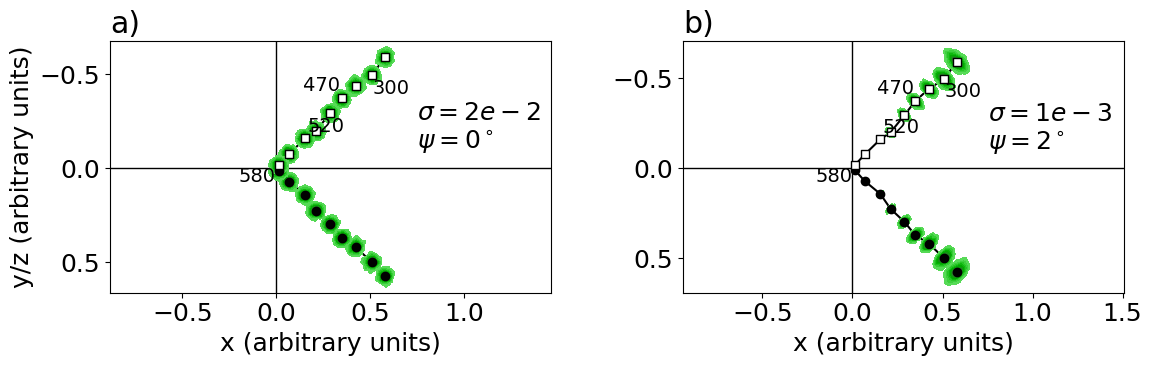

In [16]:
from scipy.stats import multivariate_normal
import seaborn as sns
np.random.seed(312338)
#Create a set of synthetic data

Ts_base_new=Ts_base[::3]
zijd_data=np.repeat([np.linspace(1/np.sqrt(3),0,len(Ts_base_new))],3,axis=0).T
zijd_data[:,2]=-zijd_data[:,1]

fig,ax=plt.subplots(1,2,figsize=(12,4))

#Sample from the noise distribution with moderate sigma and psi
sigma=1e-2
psi=np.radians(0.5)

#Add Noise to the Zijderveld data
for i in range(len(zijd_data)):
    B2=np.sum(zijd_data[i]**2)
    BTB=np.outer(zijd_data[i],zijd_data[i])
    #Create covariance matrix
    C=np.identity(3)*(sigma**2+B2*psi**2)-BTB*psi**2
    #Sample from distribution
    zijd_data[i]=multivariate_normal.rvs(zijd_data[i],C)

#Sample from a noise distribution with high sigma, zero psi
sigma=2e-2
psi=0
for i in range(len(zijd_data)):
    B2=np.sum(zijd_data[i]**2)
    BTB=np.outer(zijd_data[i],zijd_data[i])
    #Create covariance matrix
    C=np.identity(3)*(sigma**2+B2*psi**2)-BTB*psi**2
    #Sample from distribution
    rngs=multivariate_normal.rvs(zijd_data[i],C,1000)
    #Plot on Zijderveld plot
    sns.kdeplot(x=rngs[:,0],y=rngs[:,1],color='g',ax=ax[0],shade=True,shade_lower=False)
    sns.kdeplot(x=rngs[:,0],y=rngs[:,2],color='g',ax=ax[0],shade=True,shade_lower=False)
    
#Sample from a noise distribution with high sigma, zero psi
sigma=1e-3
psi=np.radians(2)
for i in range(len(zijd_data)):
    B2=np.sum(zijd_data[i]**2)
    BTB=np.outer(zijd_data[i],zijd_data[i]) 
    #Create covariance matrix
    C=np.identity(3)*(sigma**2+B2*psi**2)-BTB*psi**2
    #Sample from distribution
    rngs=multivariate_normal.rvs(zijd_data[i],C,1000)
    #Plot on Zijderveld plot
    sns.kdeplot(x=rngs[:,0],y=rngs[:,1],color='g',ax=ax[1],shade=True,shade_lower=False)
    sns.kdeplot(x=rngs[:,0],y=rngs[:,2],color='g',ax=ax[1],shade=True,shade_lower=False)
    
#Plot original (noisy) data
plot_zijd_data(ax[0],zijd_data,Ts_base_new)
plot_zijd_data(ax[1],zijd_data,Ts_base_new)

#Figure Layout
ax[0].set_xlabel('x (arbitrary units)')
ax[0].set_ylabel('y/z (arbitrary units)');
ax[0].text(0.75,-0.1,'$\sigma=2e-2$\n$\psi=0^\circ$')
ax[1].text(0.75,-0.1,'$\sigma=1e-3$\n$\psi=2^\circ$')
ax[1].set_xlabel('x (arbitrary units)')
ax[0].set_title('a)',loc='left')
ax[1].set_title('b)',loc='left')
plt.tight_layout()
plt.savefig('Figures/TROUT_likelihood.pdf')


### Figure 4 - Rescaling TROUT data to make it closer to a sigmoid function.

Starting with a set of temperatures or coercivities $x$, we can rescale these to some set of temperatures $x$ so that the resulting distribution is more symmetrical. This makes it significantly easier to fit a distribution to the data when the majority

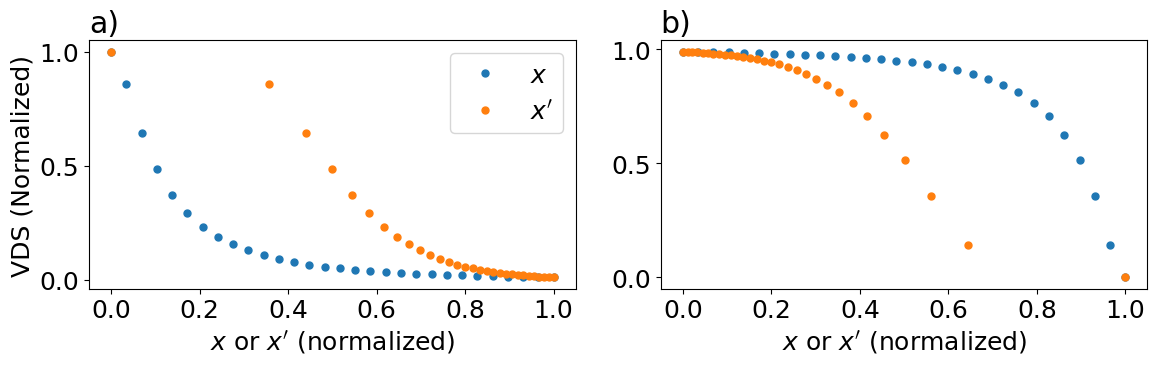

In [9]:
import scipy.stats as stats

#Produce synthetic data for the scaling process
fig,ax=plt.subplots(1,2,figsize=(12,4))
Ts_base=np.linspace(0,1,30)
Ms_scaled=1-stats.lognorm(1,scale=0.1).cdf(Ts_base)

#Find the best fitting exponent that scales the data to a tanh distribution
minimizer=minimize(bestfit_tanh,x0=[1.,0.1],args=(Ts_base,Ms_scaled),method='L-BFGS-B',bounds=([1,100],[-10,10]),options={'eps':np.sqrt(np.finfo('float32').eps)})
expon=minimizer.x[1]

#Scale the data
Ts_data=np.array(scale_xs(Ts_base,expon))

#Plot the scaled and original data
ax[0].plot(Ts_base,Ms_scaled,'.',label='$x$',markersize=10)
ax[0].plot(Ts_data,Ms_scaled,'.',label="$x'$",markersize=10)
ax[0].legend();

#Repeat the process for another set of data.
Ms_scaled_2=stats.lognorm(1,scale=0.1).cdf((1-Ts_base))
minimizer=minimize(bestfit_tanh,x0=[1.,0.1],args=(Ts_base,Ms_scaled_2),method='L-BFGS-B',bounds=([1,100],[-10,10]),options={'eps':np.sqrt(np.finfo('float32').eps)})
expon=minimizer.x[1]
Ts_data=np.array(scale_xs(Ts_base,expon))

ax[1].plot(Ts_base,Ms_scaled_2,'.',markersize=10)
ax[1].plot(Ts_data,Ms_scaled_2,'.',markersize=10)

#Figure Layout
ax[0].set_xlabel("$x$ or $x'$ (normalized)")
ax[1].set_xlabel("$x$ or $x'$ (normalized)")
ax[0].set_ylabel("VDS (Normalized)")
ax[0].set_title('a)',loc='left')
ax[1].set_title('b)',loc='left')
plt.tight_layout();
plt.savefig('Figures/data_rescaling.pdf')

### Figure 5 - Examples of the Overlap Index

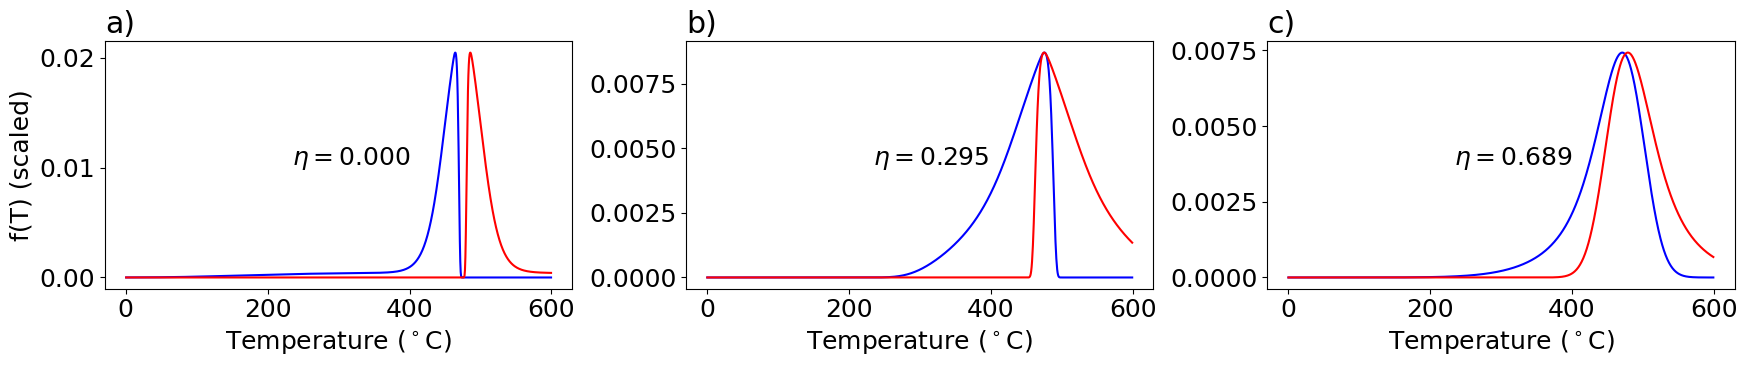

In [10]:
specimen='jm009f-czb'
zijd_data,Ts_base,Ts_data,Ts,datatype,expon=prepare_specimen_data(specimen,meas_data,sample_data,site_data)
fig,ax=plt.subplots(1,3,figsize=(18,4))
Bs=np.array([[1,0,0],[0,0,1]])
cs=np.array([1/np.sqrt(2),1/np.sqrt(2)])
mus=np.array([450,500])
sds=np.array([100,100])
ps=np.array([10,10])
q_stars=np.array([5,-5])
qs=2/np.pi*np.arctan(1/q_stars)

dist_plot(ax[0],Ts_base,cs,mus,sds,np.log(ps),q_stars,0,colors=['b','r'])
pdfs,scaled_pdfs,pred_data=get_B_ratios(Bs,Ts_data,cs,mus,sds,np.log(ps),q_stars,expon)
xs=jnp.linspace(jnp.min(Ts_base),jnp.max(Ts_base),1000)
pdfs=jnp.empty((len(cs),1000))
for k in range(len(cs)):
    pdf=cs[k]*SGG_pdf(xs,mus[k],sds[k],ps[k],qs[k])
    pdfs=pdfs.at[k].set(pdf)
for ks in combinations(range(len(pdfs)),2):
    ks=jnp.array(ks)
    pdf_pair=pdfs[ks]
    cmin=np.amin(jnp.array([cs]).T[ks])
    overlap=jnp.amin(pdf_pair,axis=0)
    overlap_sum=jnp.trapz(overlap,xs)/cmin

ax[0].annotate('$\eta=$%1.3f'%overlap_sum,xy=[0.4,0.5],xycoords='axes fraction')

mus_2=np.array([443,508])
q_stars_2=np.array([2,-2])
qs_2=2/np.pi*np.arctan(1/q_stars_2)

dist_plot(ax[1],Ts_base,cs,mus_2,sds,np.log(ps),q_stars_2,0,colors=['b','r'])


pdfs=jnp.empty((len(cs),1000))
for k in range(len(cs)):
    pdf=cs[k]*SGG_pdf(xs,mus_2[k],sds[k],ps[k],qs_2[k])
    pdfs=pdfs.at[k].set(pdf)
for ks in combinations(range(len(pdfs)),2):
    ks=jnp.array(ks)
    pdf_pair=pdfs[ks]
    cmin=np.amin(jnp.array([cs]).T[ks])
    overlap=jnp.amin(pdf_pair,axis=0)
    overlap_sum=jnp.trapz(overlap,xs)/cmin


    
ax[1].annotate('$\eta=$%1.3f'%overlap_sum,xy=[0.4,0.5],xycoords='axes fraction')


mus_3=np.array([460,490])
ps_3=np.array([2,2])
sds_3=np.array([50,50])
q_stars_3=np.array([1,-1])
qs_3=2/np.pi*np.arctan(1/q_stars_3)

dist_plot(ax[2],Ts_base,cs,mus_3,sds_3,np.log(ps_3),q_stars_3,0,colors=['b','r'])

pdfs=jnp.empty((len(cs),1000))
for k in range(len(cs)):
    pdf=cs[k]*SGG_pdf(xs,mus_3[k],sds_3[k],ps_3[k],qs_3[k])
    pdfs=pdfs.at[k].set(pdf)
for ks in combinations(range(len(pdfs)),2):
    ks=jnp.array(ks)
    pdf_pair=pdfs[ks]
    cmin=np.amin(jnp.array([cs]).T[ks])
    overlap=jnp.amin(pdf_pair,axis=0)
    overlap_sum=jnp.trapz(overlap,xs)/cmin

ax[2].annotate('$\eta=$%1.3f'%overlap_sum,xy=[0.4,0.5],xycoords='axes fraction')
num=97
for a in ax:
    a.set_title(chr(num)+')',loc='left')
    num+=1
    a.set_xlabel('Temperature ($^\circ$C)')
ax[0].set_ylabel('f(T) (scaled)')
plt.tight_layout()
plt.savefig('Figures/overlap_index_examples.pdf')

### Figure 6 - Examples of the Crossover Temperature and Multicomponent Region

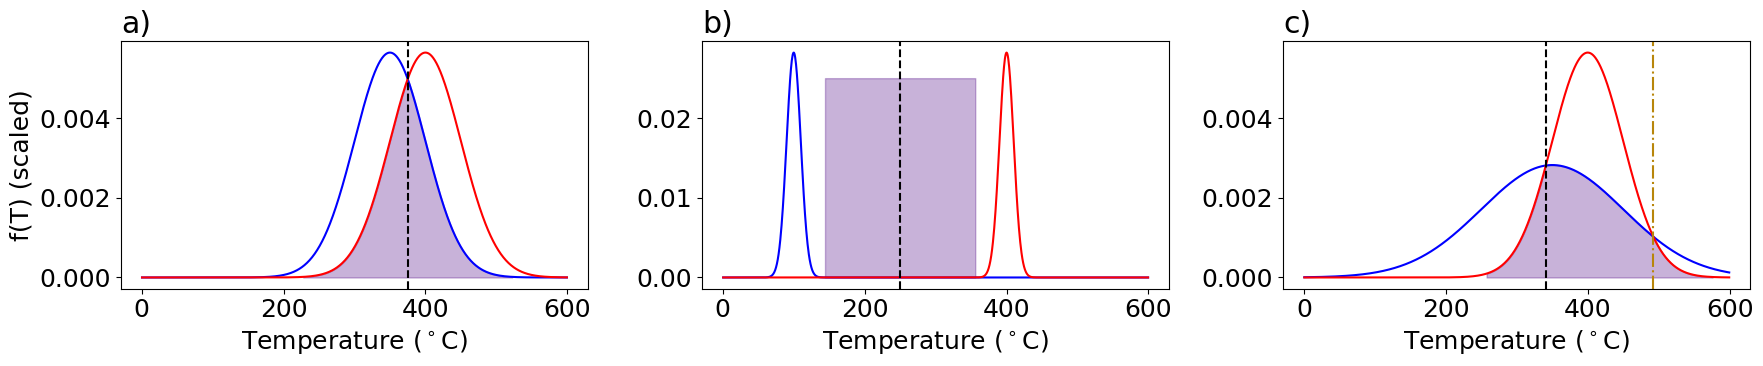

In [11]:
specimen='jm009f-czb'
zijd_data,Ts_base,Ts_data,Ts,datatype,expon=prepare_specimen_data(specimen,meas_data,sample_data,site_data)
xs_base=np.linspace(min(Ts_base),max(Ts_base),10000)[:-1]
fig,ax=plt.subplots(1,3,figsize=(18,4))
Bs=np.array([[1,0,0],[0,0,1]])
cs=np.array([1/np.sqrt(2),1/np.sqrt(2)])
mus=np.array([350,400])
sds=np.array([50,50])
ps=np.array([2,2])
q_stars=np.array([0,0])
qs=2/np.pi*np.arctan(1/q_stars)

par_dict={'Bs':Bs,'cs':cs,'mus':mus,'sds':sds,'p_stars':np.log(ps),'q_stars':q_stars}


dist_plot(ax[0],Ts_base,cs,mus,sds,np.log(ps),q_stars,0,colors=['b','r'])
pdfs,crossovers,lowers,uppers=calc_overlap_range(par_dict,Ts_base,0,desired_fraction=0.95)
minpdf=np.amin(pdfs,axis=0)
overlap_pdf=minpdf[(uppers[0][1]>xs_base)&(xs_base>lowers[0][1])]
overlap_region=xs_base[(uppers[0][1]>xs_base)&(xs_base>lowers[0][1])]



ax[0].fill_between(overlap_region,overlap_pdf,color='indigo',alpha=0.3)
ax[0].axvline(crossovers[0,1],color='k',linestyle='--')

mus_2=np.array([100,400])
sds_2=np.array([10,10])

dist_plot(ax[1],Ts_base,cs,mus_2,sds_2,np.log(ps),q_stars,0,colors=['b','r'])
par_dict['mus']=mus_2
par_dict['sds']=sds_2
pdfs,crossovers,lowers,uppers=calc_overlap_range(par_dict,Ts_base,0,desired_fraction=0.95)
minpdf=np.amin(pdfs,axis=0)
overlap_pdf=minpdf[(uppers[0][1]>xs_base)&(xs_base>lowers[0][1])]
overlap_region=xs_base[(uppers[0][1]>xs_base)&(xs_base>lowers[0][1])]


ax[1].fill_between(overlap_region,0.025,color='indigo',alpha=0.3)
ax[1].axvline(crossovers[0,1],color='k',linestyle='--')


mus_3=np.array([350,400])

sds_3=np.array([100,50])

par_dict['mus']=mus_3
par_dict['sds']=sds_3
pdfs,crossovers,lowers,uppers=calc_overlap_range(par_dict,Ts_base,0,desired_fraction=0.95)

dist_plot(ax[2],Ts_base,cs,mus_3,sds_3,np.log(ps),q_stars,0,colors=['b','r'])
minpdf=np.amin(pdfs,axis=0)
overlap_pdf=minpdf[(uppers[0][1]>xs_base)&(xs_base>lowers[0][1])]
overlap_region=xs_base[(uppers[0][1]>xs_base)&(xs_base>lowers[0][1])]

ax[2].axvline(crossovers[0,1],color='k',linestyle='--',label='Crossover T')
ax[2].axvline(crossovers[1,0],color='darkgoldenrod',linestyle='-.',label='Secondary Crossover T')

ax[2].fill_between(overlap_region,overlap_pdf,color='indigo',alpha=0.3,label='Mixed Region')
#plt.legend();
num=97
for a in ax:
    a.set_title(chr(num)+')',loc='left')
    num+=1
    a.set_xlabel('Temperature ($^\circ$C)')
ax[0].set_ylabel('f(T) (scaled)')
plt.tight_layout()
plt.savefig('Figures/analysis_definitions.pdf')

### Figure 7 - Examples of TROUT results for the Pito Deep dataset
The data generated in this figure are produced by the cell above. The CTs and MRs are plotted as MR data. 

57 of 92 minimizations successful
Best result has a log probability score of 212.3
44 of 92 minimizations successful
Best result has a log probability score of 239.4
59 of 64 minimizations successful
Best result has a log probability score of 194.2
42 of 64 minimizations successful
Best result has a log probability score of 212.5


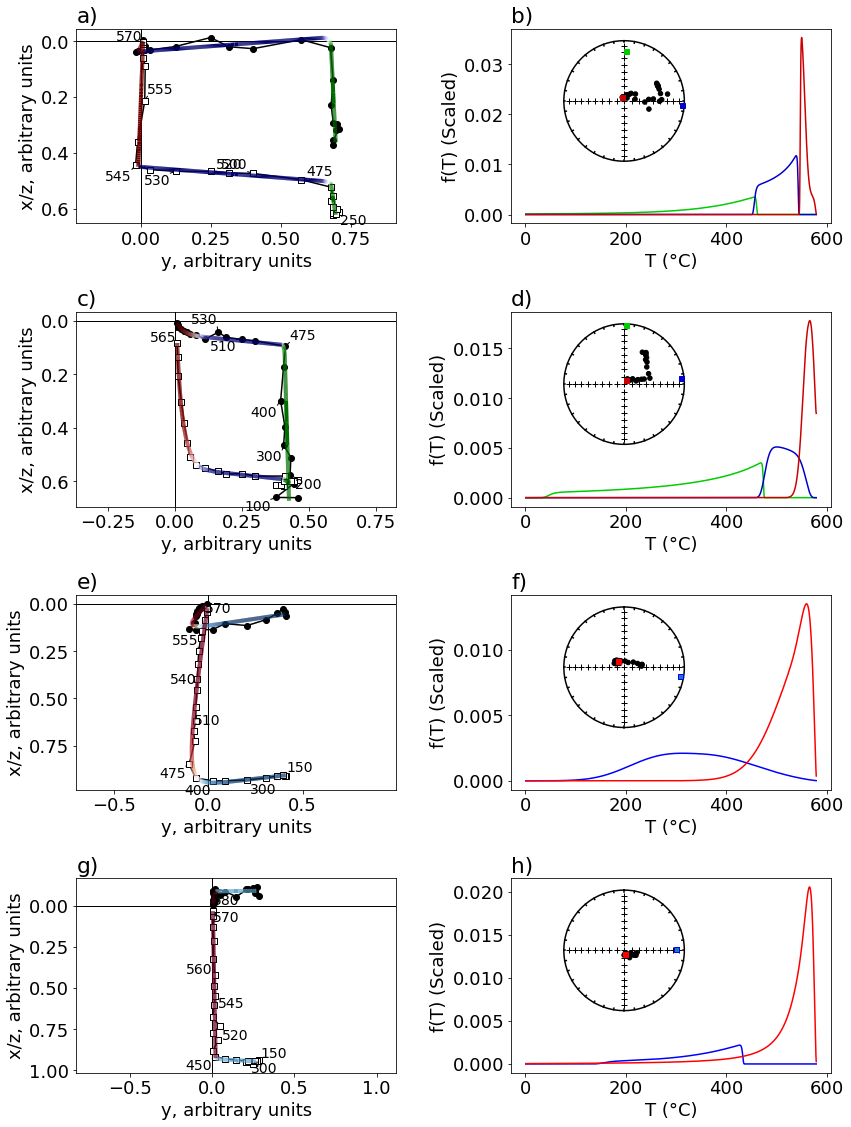

In [83]:
meas_data,sample_data,site_data=import_direction_data('PD22/')
fig,ax=plt.subplots(4,2,figsize=(12,16))

specimen='PD036a1'
zijd_data,Ts_base,Ts_data,Ts,datatype,expon=prepare_specimen_data(specimen,meas_data,sample_data,site_data)

par_dict,alt_par_dicts=find_best_fit_model(zijd_data,Ts_data,3,pop_size=4)
plot_results(zijd_data,Ts_base,Ts_data,par_dict,expon,ax=ax[0],shared_axis=1)


specimen='PD135a2'
zijd_data,Ts_base,Ts_data,Ts,datatype,expon=prepare_specimen_data(specimen,meas_data,sample_data,site_data)

par_dict,alt_par_dicts=find_best_fit_model(zijd_data,Ts_data,3,pop_size=4)
plot_results(zijd_data,Ts_base,Ts_data,par_dict,expon,ax=ax[1],shared_axis=1)

specimen='PD014d2'
zijd_data,Ts_base,Ts_data,Ts,datatype,expon=prepare_specimen_data(specimen,meas_data,sample_data,site_data)

par_dict,alt_par_dicts=find_best_fit_model(zijd_data,Ts_data,2,pop_size=4)
plot_results(zijd_data,Ts_base,Ts_data,par_dict,expon,ax=ax[2],shared_axis=1)

specimen='PD142a2'
zijd_data,Ts_base,Ts_data,Ts,datatype,expon=prepare_specimen_data(specimen,meas_data,sample_data,site_data)

par_dict,alt_par_dicts=find_best_fit_model(zijd_data,Ts_data,2,pop_size=4)
plot_results(zijd_data,Ts_base,Ts_data,par_dict,expon,ax=ax[3],shared_axis=1)

ax[0,0].set_title('a)',loc='left')
ax[0,1].set_title('b)',loc='left')
#ax].set_title('c)',loc='left',fontsize=16)
ax[1,0].set_title('c)',loc='left')
ax[1,1].set_title('d)',loc='left')
#ax[1,2].set_title('f)',loc='left',fontsize=16)
ax[2,0].set_title('e)',loc='left')
ax[2,1].set_title('f)',loc='left')
#ax[2,2].set_title('i)',loc='left',fontsize=16)
ax[3,0].set_title('g)',loc='left')
ax[3,1].set_title('h)',loc='left')
#ax[3,2].set_title('l)',loc='left',fontsize=16)
plt.tight_layout()

plt.savefig('Figures/pito_deep_examples.pdf')

### Figure 8 - All results from the TROUT model from the Pito Deep dataset

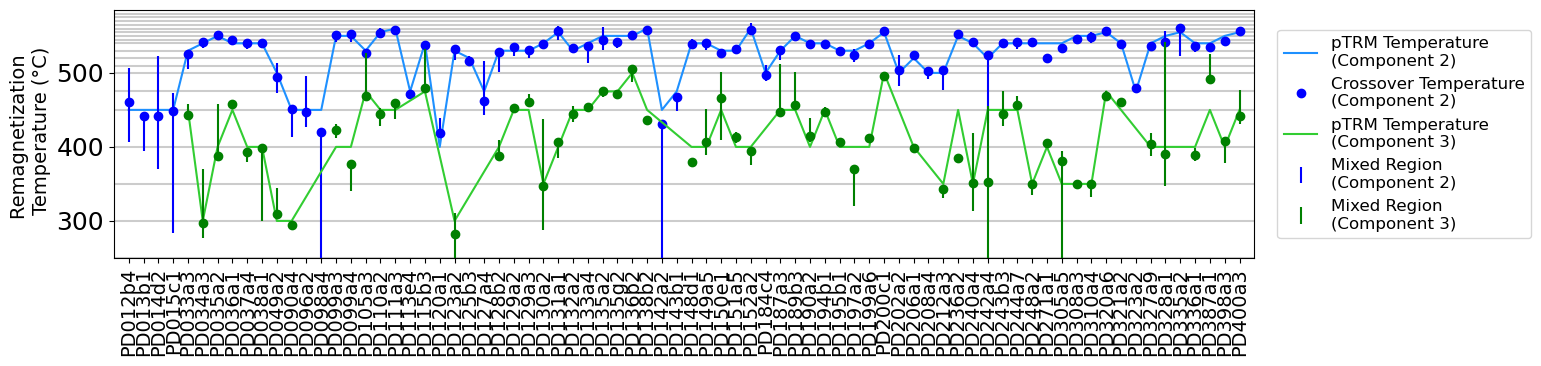

In [29]:
#Setup Figure
plt.figure(figsize=(16,4))

#Read in dataset from previously written data
pito_info=pd.read_csv('pito_info.csv')

#Read in data file.
meas_data,sample_data,site_data=import_direction_data('PD22/')

#Plot horizontal lines for each temperqature step.
for temp in meas_data.treat_temp.unique()-273:
    plt.axhline(temp,color='k',alpha=0.2)

#Plot actual reheating temperatures as blue lines.
plt.plot(pito_info.Specimen,pito_info['pTRM2 (+Y)'],color='dodgerblue',label='pTRM Temperature\n(Component 2)')

#Plot crossover temperatures as squares
plt.plot(pito_info.Specimen,pito_info.crossover_1,'bo',label='Crossover Temperature\n(Component 2)')



#Plot MRs as error bars
center_of_MR=(pito_info.lower_1+pito_info.upper_1)/2
range_of_MR=(pito_info.upper_1-pito_info.lower_1)/2
plt.errorbar(pito_info.Specimen,center_of_MR,range_of_MR,color='b',linestyle='',label='Mixed Region \n(Component 2)')

#Repeat process for lowest temperature pTRM
three_comps=pito_info.dropna(subset=['crossover_2'])

plt.plot(three_comps.Specimen,three_comps['pTRM3 (+X)'],color='limegreen',label='pTRM Temperature\n(Component 3)')
plt.plot(three_comps.Specimen,three_comps.crossover_2,'go')


center_of_MR=(pito_info.lower_2+pito_info.upper_2)/2
range_of_MR=(pito_info.upper_2-pito_info.lower_2)/2

plt.errorbar(pito_info.Specimen,center_of_MR,range_of_MR,color='g',linestyle='',label='Mixed Region\n(Component 3)')

#Plot Layout
plt.xticks(rotation=90,fontsize=14);
plt.ylabel('Remagnetization \n Temperature (°C)',fontsize=14)
plt.ylim(250,585)
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5),fontsize=12)
plt.tight_layout()
plt.xlim(-1,len(pito_info))
plt.savefig('PD22/Remag_temps.pdf');



### Figure 9 - Plot Distributions of CTs and MRs from Pito Deep dataset. 
In this plot, we look at the number of temperature steps that lie between the CT and the expected temperature, as well as the widths of the MRs for the Pito Deep Dataset

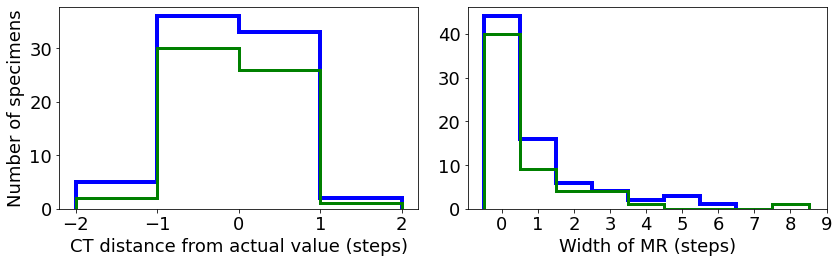

In [78]:
temps=meas_data.treat_temp.unique()-273

diffs_rb=[] #Differences in number of steps between predicted and observed pTRM 2 acquisition temperature.
diffs_bg=[] #Differences in number of steps between predicted and observed pTRM 3 acquisition temperature.
ranges_rb=[] #Multi component region between pTRM 1 and 2
ranges_bg=[] #Multi component region between pTRM 2 and 3

#Loop through specimens
for i in range(len(pito_info)):
    
    #Calculate expected and predicted crossover temperature
    t_exp=pito_info['pTRM2 (+Y)'].iloc[i]
    t_pred=pito_info['crossover_1'].iloc[i]
    
    #Find steps between expected and predicted temperature
    steps_filter=((temps>t_exp)&(temps<t_pred))|((temps<t_exp)&(temps>t_pred))
    #Find sign of difference
    diff_sign= np.sign(t_pred-t_exp)
    #Get number of steps, add +0.5 so, between 0 and 1 steps away = 0.5
    #Between 1 and 2 steps away = 1.5 etc.
    n_steps_rb=(len(temps[steps_filter])+0.5)*diff_sign
    diffs_rb.append(n_steps_rb)
    
    #Repeat proceedure for CT between pTRMs 2 and 3.
    t_exp=pito_info['pTRM3 (+X)'].iloc[i]
    t_pred=pito_info['crossover_2'].iloc[i]
    
    steps_filter=((temps>t_exp)&(temps<t_pred))|((temps<t_exp)&(temps>t_pred))
    diff_sign= np.sign(t_pred-t_exp)
    n_steps_bg=(len(temps[steps_filter])+0.5)*diff_sign
    diffs_bg.append(n_steps_bg)

    
    ### Calculate Lower and Upper bounds of MR
    lower_rb=pito_info['lower_1'].iloc[i]
    upper_rb=pito_info['upper_1'].iloc[i]
    lower_bg=pito_info['lower_2'].iloc[i]
    upper_bg=pito_info['upper_2'].iloc[i]
    
    #Check there's no nan MRs (i.e. no overlap!).
    if np.isnan(lower_rb)==False:
        #filter temperatures for those between bounds
        temps_filter=(temps>lower_rb)&(temps<upper_rb)
        #Check number of temp steps. Subtract 1 because
        #An MR spanning two steps has a width of 1.
        ranges_rb.append(len(temps[temps_filter])-1);
        
    #Repeat for second set of MRs  
    if np.isnan(lower_bg)==False:
        temps_filter=(temps>lower_bg)&(temps<upper_bg)
        ranges_bg.append(len(temps[temps_filter])-1);

#Convert to arrays
ranges_rb=np.array(ranges_rb)
ranges_bg=np.array(ranges_bg)

#If the MR doesn't even include a temperature step,
#It's 0, not -1
ranges_rb[ranges_rb<0]=0
ranges_bg[ranges_bg<0]=0

#Set up Figure
fig,ax=plt.subplots(1,2,figsize=(12,4))

#Make histograms of the CT distances
ax[0].hist(diffs_rb,bins=np.arange(np.nanmin(diffs_rb),np.nanmax(diffs_rb)+2)-0.5,rwidth=0.9,color='b',histtype='step',lw=4);
ax[0].hist(diffs_bg,bins=np.arange(np.nanmin(diffs_bg),np.nanmax(diffs_bg)+2)-0.5,rwidth=0.9,color='g',histtype='step',lw=3);

#Make histograms of the MR widths.
ax[1].hist(ranges_rb,bins=np.arange(np.nanmin(ranges_rb),np.nanmax(ranges_rb)+2)-0.5,rwidth=0.9,color='b',histtype='step',lw=4);
ax[1].hist(ranges_bg,bins=np.arange(np.nanmin(ranges_bg),np.nanmax(ranges_bg)+2)-0.5,rwidth=0.9,color='g',histtype='step',lw=3);

#Plot Layout
ax[1].set_xticks(np.arange(0,10))
ax[0].set_xlabel('CT distance from actual value (steps)')
ax[0].set_ylabel('Number of specimens')
plt.xlabel('Width of MR (steps)')
plt.tight_layout()
plt.savefig('Figures/Pito_n_steps.pdf')

### Figure 10 - Running Simple Trout Models on specimen data
We can fit data to the TROUT model using the function `find_best_fit_model()`. This function takes the demag data, the scaled temperatures and the number of components as arguments. An optional keyword argument is `pop_size` which tells the sampler how many minimizations to run. 

32 of 64 minimizations successful
Best result has a log probability score of 241.1
27 of 64 minimizations successful
Best result has a log probability score of 207.0
34 of 64 minimizations successful
Best result has a log probability score of 225.5


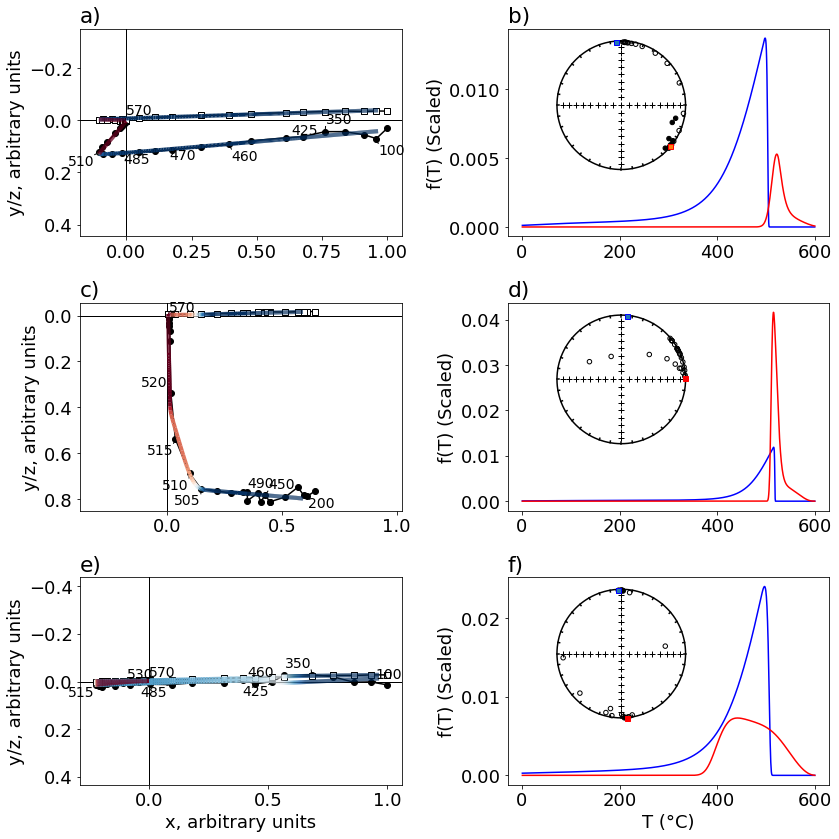

In [20]:
meas_data,sample_data,site_data=import_direction_data('SantosTauxeSpecimens/')
fig,ax=plt.subplots(3,2,figsize=(12,12))

specimen='mc117d-szb' #Choose specimen
#Set up data for TROUT model
zijd_data,Ts_base,Ts_data,Ts,datatype,expon=prepare_specimen_data(specimen,meas_data,sample_data,site_data)
#Find the best fitting set of parameters. par_dict is the best fitting TROUT model.
par_dict,alt_par_dicts=find_best_fit_model(zijd_data,Ts_data,2,pop_size=4)
#Plot_results- par_dict is requred for the fit to be plotted. 'expon' is required for the scaling.
plot_results(zijd_data,Ts_base,Ts_data,par_dict,expon,ax=ax[0],hide_xlabel=True)

#Repeat process with two more specimens.
specimen='jm009f-czb'
zijd_data,Ts_base,Ts_data,Ts,datatype,expon=prepare_specimen_data(specimen,meas_data,sample_data,site_data)
par_dict,alt_par_dicts=find_best_fit_model(zijd_data,Ts_data,2,pop_size=4)
plot_results(zijd_data,Ts_base,Ts_data,par_dict,expon,ax=ax[1],hide_xlabel=True)

specimen='mc117e-szb'
zijd_data,Ts_base,Ts_data,Ts,datatype,expon=prepare_specimen_data(specimen,meas_data,sample_data,site_data)
par_dict,alt_par_dicts=find_best_fit_model(zijd_data,Ts_data,2,pop_size=4)
plot_results(zijd_data,Ts_base,Ts_data,par_dict,expon,ax=ax[2])

#Plot Layout.
ax[0,0].set_title('a)',loc='left')
ax[0,1].set_title('b)',loc='left')
ax[1,0].set_title('c)',loc='left')
ax[1,1].set_title('d)',loc='left')
ax[2,0].set_title('e)',loc='left')
ax[2,1].set_title('f)',loc='left')
plt.tight_layout()

plt.savefig('Figures/fragile_curvature_examples.pdf')

The following cell runs the TROUT analysis for all specimens in the dataset of Santos & Tauxe. Convert the cell type from "raw" to "code" to run it.

### Figure 11 - Bulk analysis of the Santos & Tauxe (2019) dataset. 

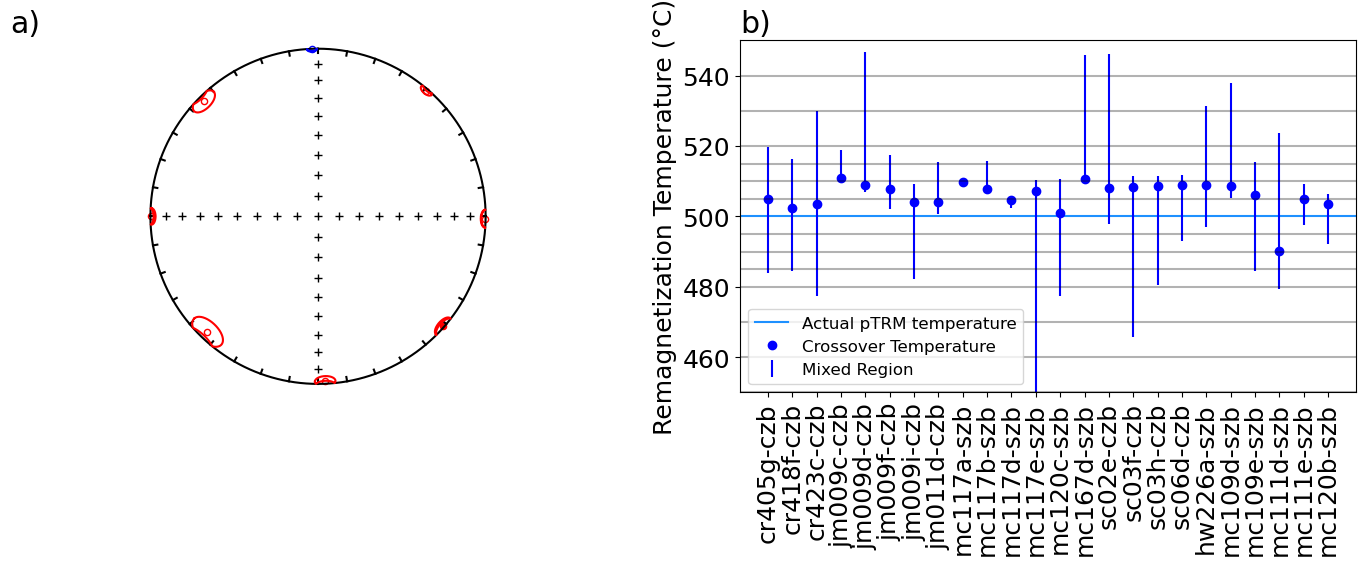

In [7]:
#Set up figure plotting.
fig=plt.figure(figsize=(14,6))
ax=fig.add_subplot(1,2,1)
ipmag.plot_net()

#Read in data
meas_data,sample_data,site_data=import_direction_data('SantosTauxeSpecimens/')
#Odd capitalization amongst speciments- fix this
specs=meas_data.specimen.str.lower().unique()

#Read in results from previous cell.
SantosTauxeResults=pd.read_csv('SantosTauxeSpecimens/specimen_fits/results_minimizer.csv')

#Loop through different directions (expected directions)
for dec_high_exp in SantosTauxeResults.dec_high_exp.unique():
    #Grab subset of directions
    subset=SantosTauxeResults[SantosTauxeResults.dec_high_exp==dec_high_exp]
    
    #Get predicted direction
    subset_dirs=subset.loc[:,'dec_high_pred':'inc_high_pred'].values
    
    #Calculate Mean Direction and Alpha 95
    carts=pmag.dir2cart(subset_dirs)
    R_cart=np.sum(carts,axis=0)
    R=np.linalg.norm(R_cart)
    N=len(subset)
    k=(N-1)/(N-R)
    a95=140/np.sqrt(k*N)
    
    #Convert back to a direction and plot:
    R_dir=pmag.cart2dir(R_cart)
    ipmag.plot_di_mean(R_dir[0],R_dir[1],a95,color='r')
    


#Repeat procedure with low temperature direction (all specimens)
low_dirs=SantosTauxeResults.loc[:,'dec_low_pred':'inc_low_pred'].values
carts=pmag.dir2cart(low_dirs)
R_cart=np.sum(carts,axis=0)
R=np.linalg.norm(R_cart)
N=len(low_dirs)
k=(N-1)/(N-R)

a95=140/np.sqrt(k*N)
R_dir=pmag.cart2dir(R_cart)
ipmag.plot_di_mean(R_dir[0],R_dir[1],a95,color='b')

#Add title to axis
ax.set_title('a)',loc='left')

#Create plot of Crossover Temperatures and Mixed regions.
ax=fig.add_subplot(1,2,2)

#Plot expected crossover temperature at 500 degrees
plt.axhline(500,color='dodgerblue',label='Actual pTRM temperature')

#Plot MR as vertical errorbar
percentiles=SantosTauxeResults.loc[:,'min_percentile':'max_percentile'].values
plt.errorbar(specs,(percentiles[:,0]+percentiles[:,1])/2,(percentiles[:,1]-percentiles[:,0])/2,linestyle='',color='b',label='Mixed Region');

#Plot Crossovers as points
crossings=SantosTauxeResults.crossovers.values
plt.plot(specs,crossings,'bo',label='Crossover Temperature')


#Figure Layout
plt.xticks(rotation=90);
plt.legend(fontsize=12,loc='lower left');
for temp in meas_data.treat_temp.unique()-273:
    if temp!=500:
        plt.axhline(temp,color='k',alpha=0.3)
plt.ylim(450,550)
plt.ylabel('Remagnetization Temperature (°C)')
plt.tight_layout()
ax.set_title('b)',loc='left')
plt.savefig('SantosTauxeSpecimens/site_fit/santos_tauxe_results.pdf')

### Figure 12 - Example of the TROUT method applied to the dataset of Kent & Gee (1994)

24 of 32 minimizations successful
Best result has a log probability score of 272.9


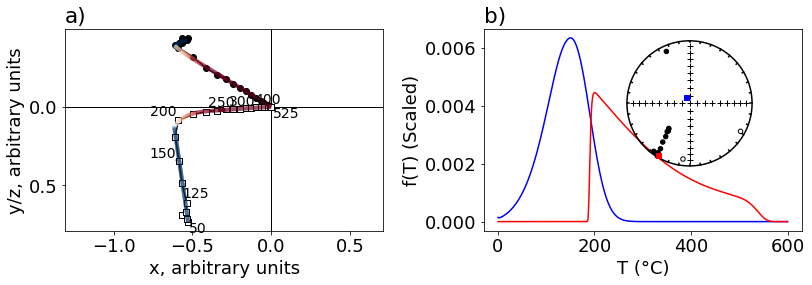

In [38]:
#Run the TROUT Model
meas_data,sample_data,site_data=import_direction_data('MORBReheating/')
specimens=meas_data.specimen.unique()
specimen='c114-10.43'
zijd_data,Ts_base,Ts_data,Ts,datatype,expon=prepare_specimen_data(specimen,meas_data,sample_data,site_data)

#Run the TROUT model to obtain the best fitting result to the data.
par_dict,alt_par_dicts=find_best_fit_model(zijd_data,Ts_data,2,
                                       post_func=post_func_sigma_psi)


#Importantly, the analysis we used here doesn't include the original direction of the TRM
#Prior to fixing for the paleointensity experiment. However, this is included in the 
#Figure in the original paper so I append it to the data on the Zijderveld plot before 
#Plotting.
specframe=meas_data[meas_data.specimen==specimen]
zijd_dir=np.array([specframe['dir_dec'].values,specframe['dir_inc'].values,specframe['magn_moment'].values]).T
zijd_data=pmag.dir2cart(zijd_dir)

zijd_data/=np.amax(np.linalg.norm(zijd_data,axis=1))
Ts_base=np.append(0.,Ts_base)
Ts_data=np.append(0.,Ts_data)
fig,ax=plt.subplots(1,2,figsize=(12,4))


#Plot our results:

#Figure Layout:
plot_results(zijd_data,Ts_base,Ts_data,par_dict,expon,inset_loc='upper right',ax=ax)
ax[0].set_title('a)',loc='left')
ax[1].set_title('b)',loc='left')
plt.savefig('MORBReheating/'+specimen+'.pdf')



### Figure 13 - Bulk results for the Kent & Gee (1994) dataset

18 of 32 minimizations successful
Best result has a log probability score of 246.4
18 of 32 minimizations successful
Best result has a log probability score of 238.9
18 of 32 minimizations successful
Best result has a log probability score of 272.9
19 of 32 minimizations successful
Best result has a log probability score of 284.4
16 of 32 minimizations successful
Best result has a log probability score of 301.0


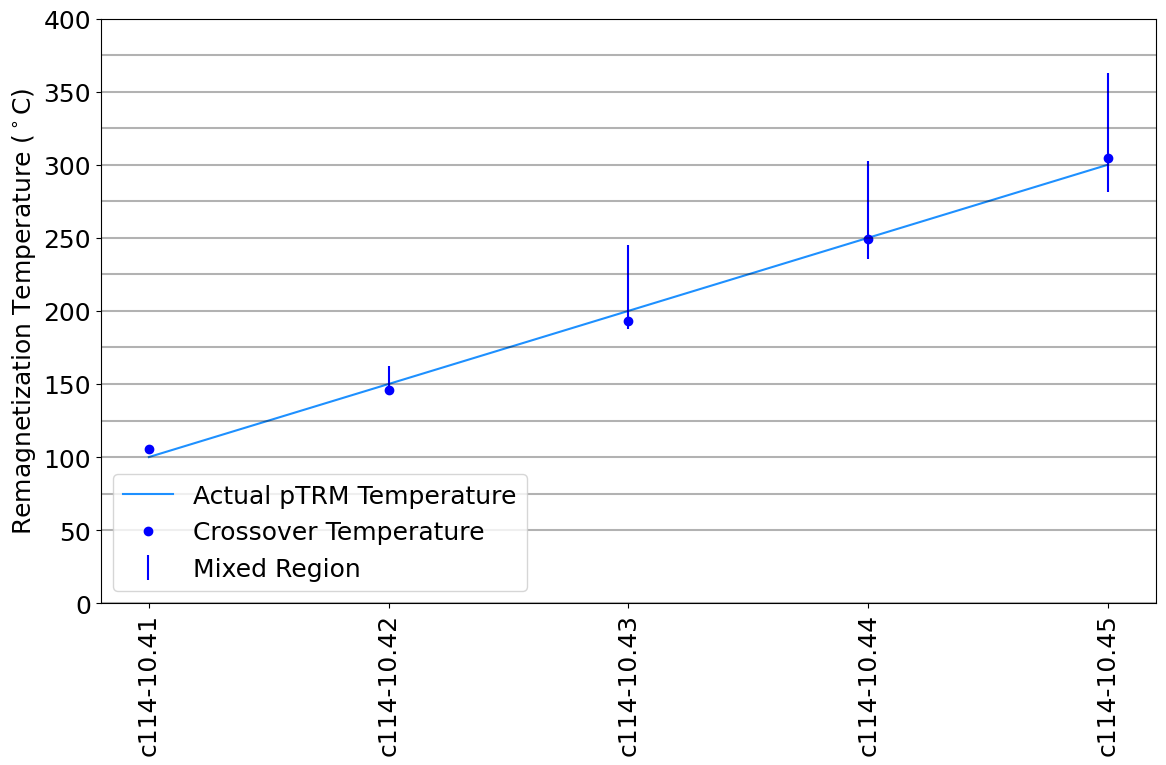

In [30]:
plt.figure(figsize=(12,8))
meas_data,sample_data,site_data=import_direction_data('MORBReheating/')
specimens=meas_data.specimen.unique()

#Plot line with expected value of specimens.
plt.plot(specimens[:-1],[100,150,200,250,300],color='dodgerblue',label='Actual pTRM Temperature')

for specimen in specimens[:-1]:
    #Plot Zijderveld data 
    zijd_data,Ts_base,Ts_data,Ts,datatype,expon=prepare_specimen_data(specimen,meas_data,sample_data,site_data)    
    par_dict,alt_par_dicts=find_best_fit_model(zijd_data,Ts_data,2,
                                       post_func=post_func_sigma_psi)
    pdfs,crossovers,lowers,uppers=calc_overlap_range(par_dict,Ts_base,expon)
    plt.plot(specimen,crossovers[0,1],'bo')
    plt.errorbar(specimen,(lowers[0,1]+uppers[0,1])/2,(uppers[0,1]-lowers[0,1])/2,color='b')
for temp in Ts_base:
    plt.axhline(temp,color='k',alpha=0.3)

plt.plot(specimen,500,'bo',label='Crossover Temperature')
plt.errorbar(specimen,500,yerr=1,color='b',linestyle='',label='Mixed Region')
plt.ylim(0,400)
plt.xticks(rotation='vertical')
plt.ylabel('Remagnetization Temperature ($^\circ$C)')
plt.legend();
plt.tight_layout();
plt.savefig('MORBReheating/temp_results.pdf')

The next cell calculates the bulk CT and MR of the Pito Deep dataset. Change the cell type from "raw" to "code" to run. Read the comments carefully for examples of extracting MRs and CTs.

### Figure 14 - Example of unmixing an IRM overprint on a TRM, where TROUT does not work due to non-uniqueness

This figure applies TROUT to a specimen from the dataset of Tauxe & Santos (2019)

144 of 256 minimizations successful
Best result has a log probability score of 124.3


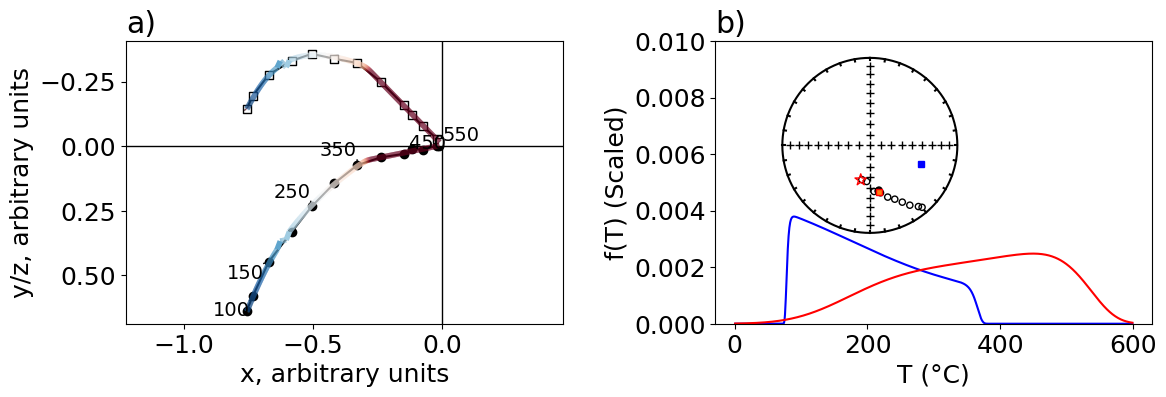

In [6]:
meas_data,sample_data,site_data=import_direction_data('SFVolc/')
specimen='sv18i2' #Name of the specimen we want to plot

zijd_data,Ts_base,Ts_data,Ts,datatype,expon=prepare_specimen_data(specimen,meas_data,sample_data,site_data)
par_dict,alt_par_dicts=find_best_fit_model(zijd_data,Ts_data,2,pop_size=16)
dec,inc=site_data[site_data.site=='sv18'].iloc[-1,9:11].values

fig,ax=plt.subplots(1,2,figsize=(12,4))
plot_results(zijd_data,Ts_base,Ts_data,par_dict,expon,ax=ax)
ipmag.plot_di(dec,inc,color='r',marker='*',markersize=75)
ax[1].set_ylim(0,0.01)
ax[0].set_title('a)',loc='left')
ax[1].set_title('b)',loc='left')
plt.savefig('Figures/Supplement_sv18i2.pdf')

### Figure 15 - Markov Chain Monte Carlo Approximations of the posterior
This Figure attempts to approximate the posterior distribution using a markov chain monte carlo sampler (warning, takes a while to run).

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.24it/s]


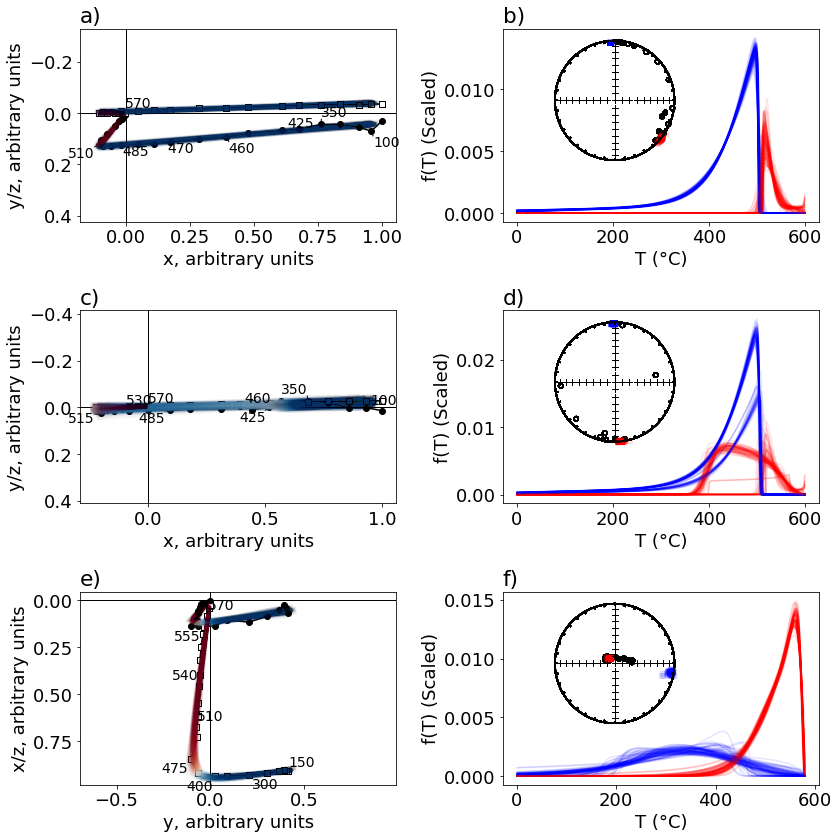

In [15]:
meas_data,sample_data,site_data=import_direction_data('SantosTauxeSpecimens/')
fig,ax=plt.subplots(3,2,figsize=(12,12))

#Prepare specimens for fitting
specimen='mc117d-szb'
zijd_data,Ts_base,Ts_data,Ts,datatype,expon=prepare_specimen_data(specimen,meas_data,sample_data,site_data)
#Perform markov chain monte carlo fits. n_samples is the number of samples in each chain.
par_dict,alt_par_dicts=find_best_fit_emcee(zijd_data,Ts_data,2,pop_size=4,n_samples=10000)
#Plot_results_emcee plots the results
plot_results_emcee(zijd_data,Ts_base,Ts_data,alt_par_dicts,expon,ax=ax[0])

#Repeat process for two more specimens.
specimen='mc117e-szb'
zijd_data,Ts_base,Ts_data,Ts,datatype,expon=prepare_specimen_data(specimen,meas_data,sample_data,site_data)
par_dict,alt_par_dicts=find_best_fit_emcee(zijd_data,Ts_data,2,pop_size=4,n_samples=10000)
plot_results_emcee(zijd_data,Ts_base,Ts_data,alt_par_dicts,expon,ax=ax[1])

meas_data,sample_data,site_data=import_direction_data('PD22/')
specimen='PD014d2'
zijd_data,Ts_base,Ts_data,Ts,datatype,expon=prepare_specimen_data(specimen,meas_data,sample_data,site_data)
par_dict,alt_par_dicts=find_best_fit_emcee(zijd_data,Ts_data,2,pop_size=4,n_samples=10000)
plot_results_emcee(zijd_data,Ts_base,Ts_data,alt_par_dicts,expon,ax=ax[2],shared_axis=1)

#Figure Layout
ax[0,0].set_title('a)',loc='left')
ax[0,1].set_title('b)',loc='left')
ax[1,0].set_title('c)',loc='left')
ax[1,1].set_title('d)',loc='left')
ax[2,0].set_title('e)',loc='left')
ax[2,1].set_title('f)',loc='left')
plt.tight_layout()
plt.savefig('Figures/MCMC_Uncertainties.pdf')

### Writing to file
Running the TROUT model and writing to the specimens.txt file can be done using the TROUT_write function

In [140]:
#Import Pito Deep Data
pito_info=pd.read_excel('PD22/Pito_pTRM_info.xlsx')
meas_data,sample_data,site_data=import_direction_data('PD22/')

#Loop through specimens.
for specimen in pito_info.Specimen.unique():
    #Prepare data for the TROUT model
    zijd_data,Ts_base,Ts_data,Ts,datatype,expon=prepare_specimen_data(specimen,meas_data,sample_data,site_data)
    #Check that there's a third component, otherwise there's only two.
    if np.isnan(pito_info.loc[pito_info.Specimen==specimen,'pTRM3 (+X)'].iloc[0]):
        n_components=2
    else:
        n_components=3
    TROUT_write('PD22/',specimen,n_components,pop_size=4)

Writing data for specimen PD012b4
54 of 64 minimizations successful
Best result has a log probability score of 207.9
244  records written to file  PD22/specimens.txt
Writing data for specimen PD013b1
37 of 64 minimizations successful
Best result has a log probability score of 217.3
244  records written to file  PD22/specimens.txt
Writing data for specimen PD014d2
59 of 64 minimizations successful
Best result has a log probability score of 194.2
244  records written to file  PD22/specimens.txt
Writing data for specimen PD015c1
52 of 64 minimizations successful
Best result has a log probability score of 209.0
244  records written to file  PD22/specimens.txt
Writing data for specimen PD033a3
28 of 92 minimizations successful
Best result has a log probability score of 196.0
245  records written to file  PD22/specimens.txt
Writing data for specimen PD034a3
59 of 92 minimizations successful
Best result has a log probability score of 220.9
246  records written to file  PD22/specimens.txt
Writ

In [144]:
meas_data,sample_data,site_data=import_direction_data('SantosTauxeSpecimens/')

#Loop through specimens.
n_components=2
for specimen in meas_data.specimen.unique():
    TROUT_write('SantosTauxeSpecimens/',specimen,n_components,pop_size=4)

Writing data for specimen Cr405g-czb
32 of 64 minimizations successful
Best result has a log probability score of 299.1
26  records written to file  SantosTauxeSpecimens/specimens.txt
Writing data for specimen Cr418f-czb
44 of 64 minimizations successful
Best result has a log probability score of 267.3
28  records written to file  SantosTauxeSpecimens/specimens.txt
Writing data for specimen Cr423c-czb
34 of 64 minimizations successful
Best result has a log probability score of 263.5
30  records written to file  SantosTauxeSpecimens/specimens.txt
Writing data for specimen Jm009c-czb
19 of 64 minimizations successful
Best result has a log probability score of 208.7
32  records written to file  SantosTauxeSpecimens/specimens.txt
Writing data for specimen Jm009d-czb
53 of 64 minimizations successful
Best result has a log probability score of 183.1
34  records written to file  SantosTauxeSpecimens/specimens.txt
Writing data for specimen Jm009f-czb
25 of 64 minimizations successful
Best resu

In [145]:
meas_data,sample_data,site_data=import_direction_data('MORBReheating/')

#Loop through specimens.
n_components=2
for specimen in meas_data.specimen.unique():
    TROUT_write('MORBReheating/',specimen,n_components,pop_size=4)

Writing data for specimen c114-10.41
35 of 64 minimizations successful
Best result has a log probability score of 246.1
14  records written to file  MORBReheating/specimens.txt
Writing data for specimen c114-10.42
40 of 64 minimizations successful
Best result has a log probability score of 239.5
16  records written to file  MORBReheating/specimens.txt
Writing data for specimen c114-10.43
35 of 64 minimizations successful
Best result has a log probability score of 272.9
18  records written to file  MORBReheating/specimens.txt
Writing data for specimen c114-10.44
30 of 64 minimizations successful
Best result has a log probability score of 303.4
20  records written to file  MORBReheating/specimens.txt
Writing data for specimen c114-10.45
48 of 64 minimizations successful
Best result has a log probability score of 301.0
22  records written to file  MORBReheating/specimens.txt
Writing data for specimen c114-10.46
37 of 64 minimizations successful
Best result has a log probability score of 2

In [48]:
import pandas as pd
from pmagpy import pmag
WD='MORBReheating/'
for tname in ['measurements.txt','specimens.txt','samples.txt','sites.txt']:
    mfile=pd.read_csv(WD+tname,sep='\t',skiprows=1)
    try:
        print(mfile.specimen.unique())
    except:
        pass
    try:
        print(mfile.sample.unique())
    except:
        pass
    try:

        print(mfile.site.unique())
    except:
        pass
    mfile['citations']='this_study:'+mfile['citations']
    print(mfile['citations'])
    pmag.magic_write(WD+tname,mfile,tname[:-4],dataframe=True)


['c114-10.41' 'c114-10.42' 'c114-10.43' 'c114-10.44' 'c114-10.45'
 'c114-10.46']
0      this_study:10.1126/science.265.5178.1561
1      this_study:10.1126/science.265.5178.1561
2      this_study:10.1126/science.265.5178.1561
3      this_study:10.1126/science.265.5178.1561
4      this_study:10.1126/science.265.5178.1561
                         ...                   
143    this_study:10.1126/science.265.5178.1561
144    this_study:10.1126/science.265.5178.1561
145    this_study:10.1126/science.265.5178.1561
146    this_study:10.1126/science.265.5178.1561
147    this_study:10.1126/science.265.5178.1561
Name: citations, Length: 148, dtype: object
148  records written to file  MORBReheating/measurements.txt
['c114-10.41' 'c114-10.42' 'c114-10.43' 'c114-10.44' 'c114-10.45'
 'c114-10.46']
0     this_study:10.1126/science.265.5178.1561
1     this_study:10.1126/science.265.5178.1561
2     this_study:10.1126/science.265.5178.1561
3     this_study:10.1126/science.265.5178.1561
4     this_study:

In [49]:
from pmagpy import ipmag
for tname in ['measurements.txt','specimens.txt','samples.txt','sites.txt']:
    flist=['PD22/'+tname,'SantosTauxeSpecimens/'+tname,'MORBReheating/'+tname]
    ipmag.combine_magic(flist,'combined/'+tname,magic_table=tname[:-4])

-I- overwriting /home/brendan/Dropbox/Apps/Overleaf/TRM Unmixing/combined/measurements.txt
-I- 2568 records written to measurements file
-I- Removed 99 redundant records from specimens table
-I- overwriting /home/brendan/Dropbox/Apps/Overleaf/TRM Unmixing/combined/specimens.txt
-I- 282 records written to specimens file
-I- overwriting /home/brendan/Dropbox/Apps/Overleaf/TRM Unmixing/combined/samples.txt
-I- 101 records written to samples file
-I- overwriting /home/brendan/Dropbox/Apps/Overleaf/TRM Unmixing/combined/sites.txt
-I- 88 records written to sites file
